# Bag of words approach on lyrics_df

In [61]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

plt.style.use('seaborn-poster')

In [153]:
def clean_lyrics(song):
    """takes lyrics and returns lemmatized words without stopwords"""
    clean_song = []
    model = spacy.load('en_core_web_sm')
    tok_song = model(song)  # parse the song through the spacy model
    for word in tok_song: # loop through words and drop stopwords, drop punctuation
        if word.is_alpha and not word.is_stop:   
            clean_song.append(word.lemma_)           
    clean_song = ' '.join(clean_song)         # return the lemmatized version to the caller as a string
    return clean_song

def evaluate_prediction(ytrue, ypred):
    scores = [round(accuracy_score(ytrue, ypred), 3), round(precision_score(ytrue, ypred, average="weighted"), 3), round(recall_score(ytrue, ypred, average="weighted"), 3), round(f1_score(ytrue, ypred, average="weighted"), 3)]
    return scores
    
def plot_confusion_matrix_heatmap(ytrue, ypred, model_description):
    #plot the heatmap
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(ytrue, ypred), annot=True, annot_kws={"size": 14}, ax = ax); #annot=True to annotate cells
    # labels, title and ticks
    ax.set_xlabel('Predicted labels', fontweight='bold');
    ax.set_ylabel('True labels', fontweight='bold'); 
    ax.set_title(f'Confusion Matrix \n {model_description}', fontsize=20, fontweight='bold', pad = 20); 
    ax.xaxis.set_ticklabels(artists, rotation=25, ha='right'); 
    ax.yaxis.set_ticklabels(artists, rotation=0)

In [144]:
def print_scores(ytrue, ypred, model_description):
    scores = evaluate_prediction(ytrue, ypred, model_description)
    print(f'**{model_description} scores:**')
    print(f'Accuracy: {scores[0]}')
    print(f'Precision: {scores[1]}')
    print(f'Recall: {scores[2]}')
    print(f'F1-score: {scores[3]}')

## 1 - clean lyrics (Spacy)

In [75]:
corpus = pd.read_csv('lyrics_df.csv', sep=';')
corpus['lyrics_clean'] = corpus['lyrics'].apply(clean_lyrics)
artists = list(corpus.artist.unique())

## 2 - transform your corpus into a matrix (CountVectorizer)

In [80]:
cv = CountVectorizer(stop_words='english')
lyrics_vec = cv.fit_transform(corpus['lyrics_clean'])

## 3 - Normalize the counts (TfidfTransformer)

In [12]:
tf = TfidfTransformer()
lyrics_vec_tf = tf.fit_transform(lyrics_vec)

## 4 - Classification model (Naive Bayes)

**Prepare dataframe**

In [14]:
lyrics_df = pd.DataFrame(lyrics_vec_tf.todense().round(2),  columns=cv.get_feature_names(), index=corpus['artist'])
lyrics_df = lyrics_df.drop(list(lyrics_df.filter(regex='^aa')), axis=1) # remove all versions of aa, aaahh, aaargh etc.
lyrics_df['artist_fact'] = pd.factorize(lyrics_df.index)[0] # factorize label column

**Define model data**

In [82]:
y = lyrics_df['artist_fact']
X = lyrics_df.reset_index(drop=True).drop(['artist_fact'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((452, 4908), (114, 4908), (452,), (114,))

**Create baseline with dummy classifier**

In [84]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_val)
dummy_clf.score(X_train, y_train)

0.42035398230088494

**Create naive bayes classifier**

In [116]:
nb = MultinomialNB(alpha=0.0025)
nb.fit(X_train, y_train)
y_pred = nb.predict(X_val)
nb.score(X_train, y_train)

0.995575221238938

**Cross validation**

In [104]:
scores = cross_val_score(nb, X_train, y_train, cv=4, scoring='accuracy')
scores.mean().round(3), scores.std().round(3)

(0.611, 0.058)

**Hyperparameter Optimization**

In [105]:
randomizedcv = RandomizedSearchCV(nb, param_distributions= {'alpha' : [x/10000 for x in range(6, 27 , 1)]})
randomizedcv.fit(X_train, y_train)
random_results = pd.DataFrame(randomizedcv.cv_results_)
columns = ['mean_test_score', 'std_test_score', 'mean_fit_time', 'param_alpha']
random_results[columns].sort_values('mean_test_score', ascending=False).head(5)

,mean_test_score,std_test_score,mean_fit_time,param_alpha
6,0.619365,0.055150,0.039941,0.0024
3,0.617143,0.052462,0.042822,0.0014
8,0.617143,0.052931,0.040294,0.0023
0,0.614945,0.049409,0.045233,0.0012
1,0.614945,0.049409,0.040663,0.001


**Test on validation data**

In [143]:
evaluate_prediction(y_val, y_pred, 'Naive Bayes')

[0.588, 0.586, 0.588, 0.572]

In [140]:
evaluate_model(nb, X_train, y_train, X_val, 'Naive Bayes')

TypeError: evaluate_model() takes 3 positional arguments but 5 were given

## 5 - Reduce class imbalance (Undersampling, Oversampling)

**Investigate training set for class imbalance**

In [38]:
y_train.value_counts(sort=False)

0     62
1     66
2    190
3    134
Name: artist_fact, dtype: int64

**Create new training sets using undersampling and oversampling techniques**

In [115]:
def test_imbalance_samplers():
    samplers = ['rus', 'nms', 'ros', 'sms']
    for sampler in samplers:
        Xtrain, ytrain = 
        
test_imbalance_samplers()

Xtrain_rus
Xtrain_nms
Xtrain_ros
Xtrain_sms


In [176]:
def test_imbalance_samplers(model, model_description, Xtrain=X_train, ytrain=y_train, Xval=X_val, yval=y_val):
    rus = RandomUnderSampler(random_state=42) #sampling_strategy={0: 2000} 
    nms = NearMiss()
    ros = RandomOverSampler(random_state=42)
    sms = SMOTE(random_state=42)
    samplers = [rus, nms, ros, sms]
    sampler_names =['Random Undersampler', 'Near Miss Sampler', 'Random Oversampler', 'SMOTE Sampler']
    scores_df = pd.DataFrame()
    for i in range(len(samplers)):
        Xtrain_resampled, ytrain_resampled = samplers[i].fit_resample(Xtrain, ytrain)
        model.fit(Xtrain_resampled, ytrain_resampled)
        ypred = model.predict(Xval)
        scores = pd.Series(evaluate_prediction(yval, ypred), index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])
        scores.name = sampler_names[i]
        scores_df = pd.concat([scores_df, scores], axis=1)
    return scores_df


In [177]:
test_imbalance_samplers(nb, 'Naive Bayes')

,Random Undersampler,Near Miss Sampler,Random Oversampler,SMOTE Sampler
Accuracy,0.588,0.518,0.588,0.579
Precision,0.627,0.538,0.613,0.596
Recall,0.588,0.518,0.588,0.579
F1-Score,0.596,0.519,0.567,0.554


In [96]:
Xtrain_rus, ytrain_rus = rus.fit_resample(X_train, y_train)
Xtrain_nms, ytrain_nms = nms.fit_resample(X_train, y_train)
Xtrain_ros, ytrain_ros = ros.fit_resample(X_train, y_train)
Xtrain_sms, ytrain_sms = sms.fit_resample(X_train, y_train)

In [97]:
pd.DataFrame({'rus': ytrain_rus.value_counts(sort=False), 'nms': ytrain_nms.value_counts(sort=False), 'ros': ytrain_ros.value_counts(sort=False), 'sms': ytrain_sms.value_counts(sort=False)})

,rus,nms,ros,sms
0,62,62,190,190
1,62,62,190,190
2,62,62,190,190
3,62,62,190,190


In [125]:
evaluate_model(nb, Xtrain_rus, ytrain_rus, X_val, 'Naive Bayes \n with RandomUndersampler')

TypeError: evaluate_model() takes 3 positional arguments but 5 were given

How does model Naive Bayes with NearMissSampler score:
The accuracy of the model is: 0.518
The precision of the model is: 0.538
The recall of the model is: 0.518
The f1-score of the model is: 0.519


<Figure size 720x576 with 0 Axes>

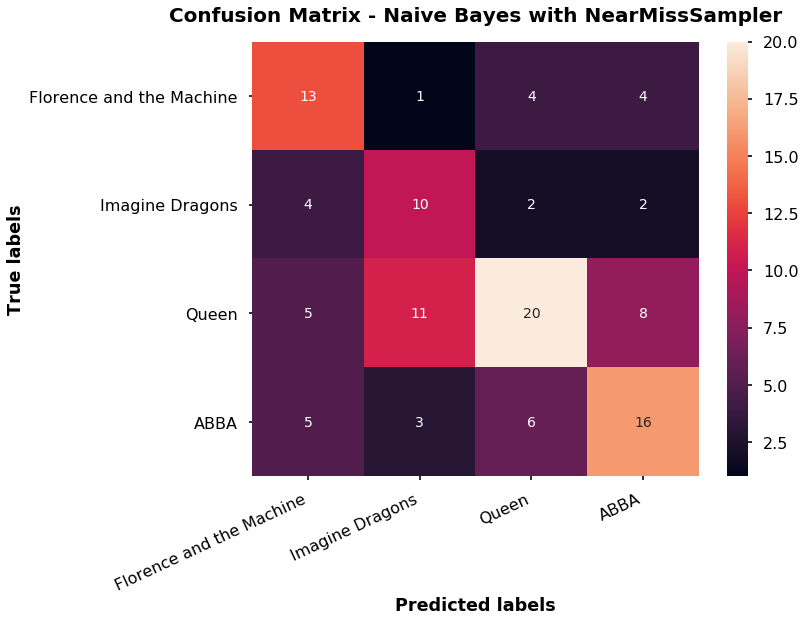

In [107]:
evaluate_model(nb, Xtrain_nms, ytrain_nms, X_val, 'Naive Bayes with NearMissSampler')

How does model Naive Bayes with RandomOversampler score:
The accuracy of the model is: 0.588
The precision of the model is: 0.613
The recall of the model is: 0.588
The f1-score of the model is: 0.567


<Figure size 720x576 with 0 Axes>

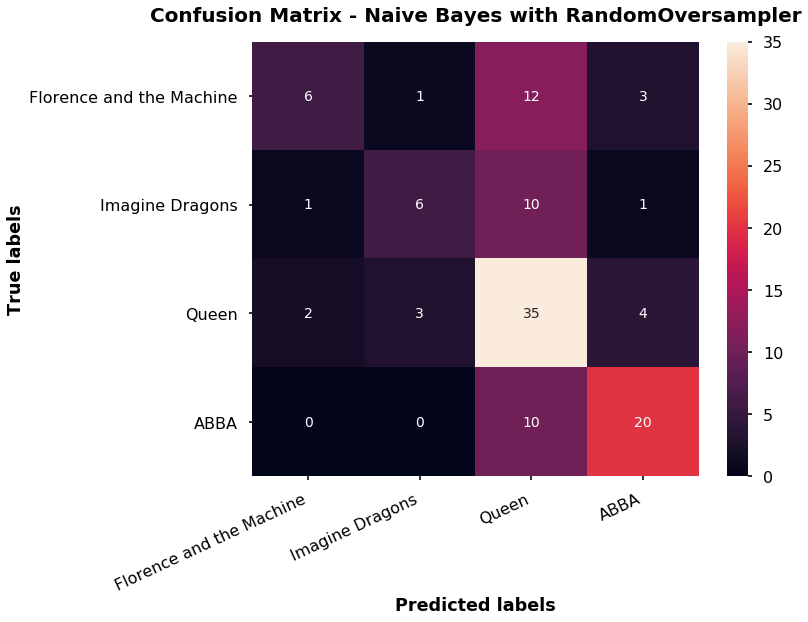

In [108]:
evaluate_model(nb, Xtrain_ros, ytrain_ros, X_val, 'Naive Bayes with RandomOversampler')

How does model Naive Bayes with SMOTE score:
The accuracy of the model is: 0.579
The precision of the model is: 0.596
The recall of the model is: 0.579
The f1-score of the model is: 0.554


<Figure size 720x576 with 0 Axes>

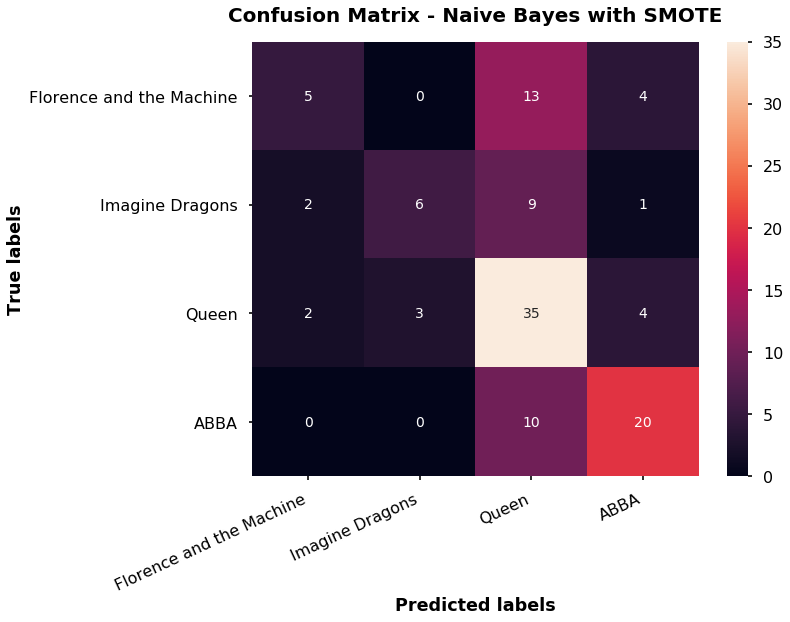

In [109]:
evaluate_model(nb, Xtrain_sms, ytrain_sms, X_val, 'Naive Bayes with SMOTE')